## Imports

In [114]:
import torch
import torch.nn as nn
import scipy.stats as stats
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import optim
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

In [115]:
from icnnet import ICNNet
from mydataset import MyDataset, get_gaussian_dataset, get_gaussian_transport_dataset
from toy_data_dataloader_gaussian import generate_gaussian_dataset

In [116]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Toy data


In [117]:
dataset = generate_gaussian_dataset(d=2, r=250, N=500)
gaussian_dataset = get_gaussian_dataset(dataset)
gaussian_transport_dataset = get_gaussian_transport_dataset(gaussian_dataset)

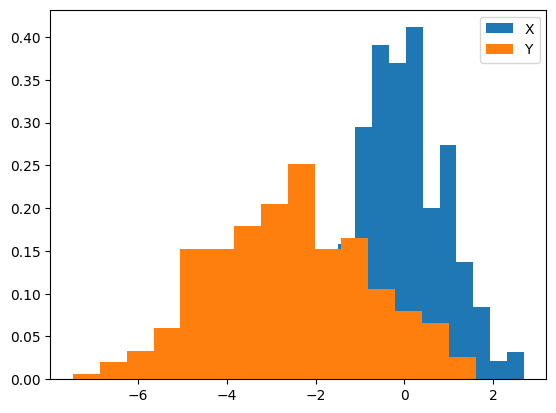

In [118]:
X = gaussian_dataset.X
Y = gaussian_dataset.Y
C = gaussian_dataset.C

test = 3
x_i = X[test, :, :]
y_i = Y[test, :, :]
c_i = C[test, :, :]


plt.hist(X[test, :, 0],  bins=15, label = 'X', density = True)
plt.hist(Y[test, :, 0],  bins=15, label = 'Y', density = True)
# plt.hist(X_pred,  bins=15, label = 'X_pred', density = True, alpha = 0.5)

plt.legend()

plt.show()

## __Training__

### PICNN training

In [119]:
gaussian_transport_dataloader = DataLoader(gaussian_transport_dataset, batch_size=50, shuffle=True)

In [120]:
epochs = 100

# Initialize the model
input_size = 2
output_size = 1

model = ICNNet(input_size = input_size, layer_sizes = [input_size, 64, 64, 64,output_size], context_layer_sizes=[input_size, 64, 64, 64,output_size])

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

for epoch in range(epochs):
    for x_batch, c_batch, y_batch in gaussian_transport_dataloader:
        x_batch.requires_grad_(True)
        c_batch.requires_grad_(True)

        optimizer.zero_grad() # Zero the gradients
        
        output = model(x_batch, c_batch)  # Assuming context c is same as input x

        loss = criterion(output, y_batch) # Compute the loss
        loss.backward() # Backward pass

        optimizer.step() # Update the parameters
        for layers_k in model.layers_z:
            for param in layers_k.parameters():
                param.data.clamp_min_(0)

    # for name, parameter in model.named_parameters():
    #     if parameter.requires_grad and parameter.grad is not None:
    #         grad_norm = parameter.grad.norm().item()
    #         print(f"Gradient norm for {name}: {grad_norm}")
    
    print(f"Epoch {epoch+1}/{epochs} Loss: {loss.item()}")

Epoch 1/100 Loss: 10.429465293884277
Epoch 2/100 Loss: 10.393009185791016
Epoch 3/100 Loss: 8.308537483215332
Epoch 4/100 Loss: 7.1752424240112305
Epoch 5/100 Loss: 7.411635398864746
Epoch 6/100 Loss: 7.0932793617248535
Epoch 7/100 Loss: 6.204054355621338
Epoch 8/100 Loss: 6.098302364349365
Epoch 9/100 Loss: 4.917076587677002
Epoch 10/100 Loss: 4.943965435028076
Epoch 11/100 Loss: 4.7674713134765625
Epoch 12/100 Loss: 4.253472328186035
Epoch 13/100 Loss: 3.832502841949463
Epoch 14/100 Loss: 4.130397796630859
Epoch 15/100 Loss: 3.68845534324646
Epoch 16/100 Loss: 3.495605230331421
Epoch 17/100 Loss: 3.6426608562469482
Epoch 18/100 Loss: 3.3707549571990967
Epoch 19/100 Loss: 3.6483960151672363
Epoch 20/100 Loss: 3.8186562061309814
Epoch 21/100 Loss: 3.5084712505340576
Epoch 22/100 Loss: 3.328667163848877
Epoch 23/100 Loss: 3.7596144676208496
Epoch 24/100 Loss: 3.546091318130493
Epoch 25/100 Loss: 3.143799304962158
Epoch 26/100 Loss: 3.380748987197876
Epoch 27/100 Loss: 3.131385087966919


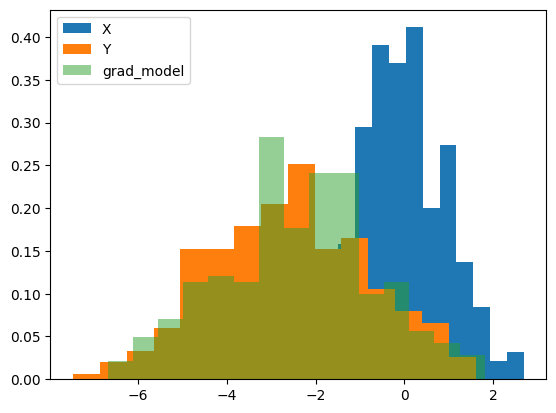

In [124]:
X = gaussian_dataset.X
Y = gaussian_dataset.Y
C = gaussian_dataset.C

#Calcul de la dérivée du PICNN

test = 3
x_i = X[test, :, :]
y_i = Y[test, :, :]
c_i = C[test, :, :]


y_i.requires_grad_(True)
x_i.requires_grad_(True)
#c_i.requires_grad_(True)    

output_model = model(x_i, c_i)

grad_model = torch.autograd.grad(outputs=output_model, inputs=x_i, grad_outputs=torch.ones_like(output_model), create_graph=True)[0]

plt.hist(X[test, :, 0],  bins=15, label = 'X', density = True)
plt.hist(Y[test, :, 0],  bins=15, label = 'Y', density = True)
plt.hist(grad_model[:, 0].detach().numpy(),  bins=15, label = 'grad_model', density = True, alpha = 0.5)
# plt.hist(X_pred,  bins=15, label = 'X_pred', density = True, alpha = 0.5)

plt.legend()

plt.show()

### PICNN training

## __Makkuva__

In [125]:
# Initialize the model
input_size = 2
output_size = 1

ICNNf = ICNNet(input_size = input_size, layer_sizes = [input_size, 64, 64, 64,output_size], context_layer_sizes=[input_size, 64, 64, 64,output_size])
ICNNg = ICNNet(input_size = input_size, layer_sizes = [input_size, 64, 64, 64,output_size], context_layer_sizes=[input_size, 64, 64, 64,output_size])

# Get the state dictionary from the trained model
state_dict = model.state_dict()

# Load the state dictionary into ICNNf and ICNNg
ICNNf.load_state_dict(state_dict)
ICNNg.load_state_dict(state_dict)

<All keys matched successfully>

In [126]:
dataloader = DataLoader(dataset, batch_size=50, shuffle=True)

epochs = 100
train_freq_g = 10

# Define the loss function and the optimizer
optimizer_f = optim.Adam(ICNNf.parameters(), lr = 0.0001)
optimizer_g = optim.Adam(ICNNg.parameters(), lr = 0.0001)

for epoch in range(epochs):
    for freq in range(train_freq_g) :
        for x, c, y in dataloader:
            # Optimizing ICNNg
            optimizer_f.zero_grad() # Zero the gradients
            optimizer_g.zero_grad() # Zero the gradients

            x.requires_grad_(True)
            y.requires_grad_(True)
            c.requires_grad_(True)

            output_g = ICNNg(y, c)
            grad_g = torch.autograd.grad(output_g, y, grad_outputs=torch.ones_like(output_g), create_graph=True)[0]

            loss_g = ICNNf(grad_g, c) - torch.sum(y * grad_g, dim=-1, keepdim=True)
            loss_g = loss_g.mean(dim=(1, 2)).mean()

            loss_g.backward() # Backward pass
            optimizer_g.step() # Update the parameters

            for layers_k in ICNNg.layers_z:
                for param in layers_k.parameters():
                    param.data.clamp_min_(0)

    for x, c, y in dataloader:
        optimizer_f.zero_grad() # Zero the gradients
        optimizer_g.zero_grad()

        x.requires_grad_(True)
        y.requires_grad_(True)
        c.requires_grad_(True)
    
        output_g = ICNNg(y, c)
        grad_g = torch.autograd.grad(outputs=output_g, inputs=y, grad_outputs=torch.ones_like(output_g), create_graph=True)[0]


        loss_f = ICNNf(x, c) - ICNNf(grad_g, c)
        loss_f =   torch.mean(loss_f) #page 24, f is updated by fixing g and maximizing (15) with a single iteration


        loss_f.backward() # Backward pass
        optimizer_f.step()
        
        for layers_k in ICNNf.layers_z:
                for param in layers_k.parameters():
                    param.data.clamp_min_(0)
        
    print(f"Epoch {epoch+1}/{epochs} loss_g: {loss_g.item()}, loss_f: {loss_f.item()}")

Epoch 1/100 loss_g: 1.7312763929367065, loss_f: -8.64115047454834
Epoch 2/100 loss_g: 1.1154192686080933, loss_f: -2.460623025894165
Epoch 3/100 loss_g: 0.3616742789745331, loss_f: -0.05216468125581741
Epoch 4/100 loss_g: -0.19516940414905548, loss_f: 0.6405482292175293
Epoch 5/100 loss_g: -0.295737087726593, loss_f: 0.8347741365432739
Epoch 6/100 loss_g: -0.05199345946311951, loss_f: 0.7643847465515137
Epoch 7/100 loss_g: -0.33383601903915405, loss_f: 0.5446187853813171
Epoch 8/100 loss_g: -0.39666226506233215, loss_f: 0.5161523818969727
Epoch 9/100 loss_g: -0.4997560381889343, loss_f: 0.26696985960006714


KeyboardInterrupt: 

In [44]:
filename_pth_f = 'ICNNf_TR.pth'
filename_pth_g = 'ICNNg_TR.pth'

In [28]:
torch.save(ICNNf.state_dict(), filename_pth_f)
torch.save(ICNNg.state_dict(), filename_pth_g)

In [45]:
input_size = 2
output_size = 1

ICNNf = ICNNet(input_size = 2, layer_sizes = [input_size,64,64,64,output_size], context_layer_sizes=[input_size,64,64,64,output_size])
ICNNf.load_state_dict(torch.load(filename_pth_f))

ICNNg = ICNNet(input_size = 2, layer_sizes = [input_size,64,64,64,output_size], context_layer_sizes=[input_size,64,64,64,output_size])
ICNNg.load_state_dict(torch.load(filename_pth_g))

RuntimeError: Error(s) in loading state_dict for ICNNet:
	Unexpected key(s) in state_dict: "layers_bn_z.0.weight", "layers_bn_z.0.bias", "layers_bn_z.0.running_mean", "layers_bn_z.0.running_var", "layers_bn_z.0.num_batches_tracked", "layers_bn_z.1.weight", "layers_bn_z.1.bias", "layers_bn_z.1.running_mean", "layers_bn_z.1.running_var", "layers_bn_z.1.num_batches_tracked", "layers_bn_z.2.weight", "layers_bn_z.2.bias", "layers_bn_z.2.running_mean", "layers_bn_z.2.running_var", "layers_bn_z.2.num_batches_tracked", "layers_bn_z.3.weight", "layers_bn_z.3.bias", "layers_bn_z.3.running_mean", "layers_bn_z.3.running_var", "layers_bn_z.3.num_batches_tracked", "layers_bn_u.0.weight", "layers_bn_u.0.bias", "layers_bn_u.0.running_mean", "layers_bn_u.0.running_var", "layers_bn_u.0.num_batches_tracked", "layers_bn_u.1.weight", "layers_bn_u.1.bias", "layers_bn_u.1.running_mean", "layers_bn_u.1.running_var", "layers_bn_u.1.num_batches_tracked", "layers_bn_u.2.weight", "layers_bn_u.2.bias", "layers_bn_u.2.running_mean", "layers_bn_u.2.running_var", "layers_bn_u.2.num_batches_tracked", "layers_bn_u.3.weight", "layers_bn_u.3.bias", "layers_bn_u.3.running_mean", "layers_bn_u.3.running_var", "layers_bn_u.3.num_batches_tracked". 

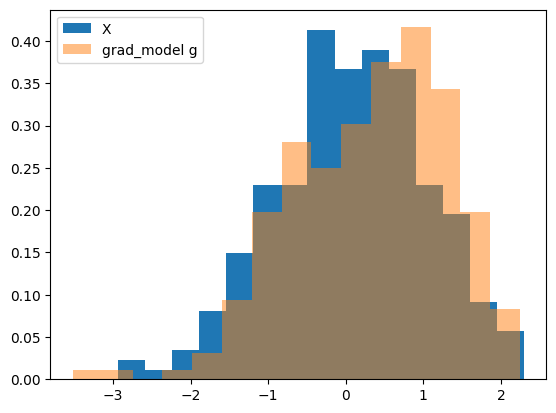

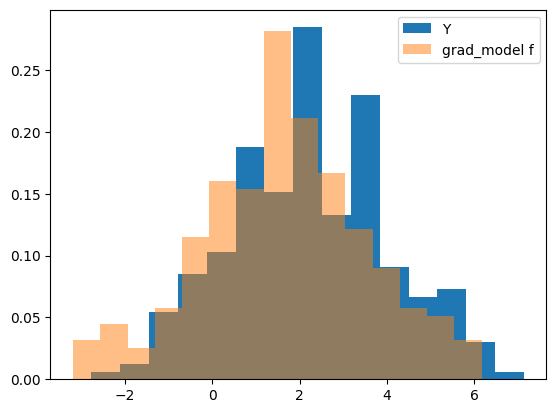

In [130]:
X = dataset.X
Y = dataset.Y
C = dataset.C

#Calcul de la dérivée du PICNN
test = 100
x_i = X[test, :, :]
y_i = Y[test, :, :]
c_i = C[test, :, :]


y_i.requires_grad_(True)
x_i.requires_grad_(True)
c_i.requires_grad_(True)    

output_model_f = ICNNf(x_i, c_i)
grad_model_f = torch.autograd.grad(outputs=output_model_f, inputs=x_i, grad_outputs=torch.ones_like(output_model), create_graph=True)[0]

output_model_g = ICNNg(y_i, c_i)
grad_model_g = torch.autograd.grad(outputs=output_model_g, inputs=y_i, grad_outputs=torch.ones_like(output_model), create_graph=True)[0]


plt.hist(X[test, :, 0],  bins=15, label = 'X', density = True)
plt.hist(grad_model_g[:, 0].detach().numpy(),  bins=15, label = 'grad_model g', density = True, alpha = 0.5)
plt.legend()
plt.show()

plt.hist(Y[test, :, 0],  bins=15, label = 'Y', density = True)
plt.hist(grad_model_f[:, 0].detach().numpy(),  bins=15, label = 'grad_model f', density = True, alpha = 0.5)
plt.legend()
plt.show()